## Notebook summary

This notebook pulls all flooding related 311 records from NYC's API and cleans them. It combines this data with flood risk boundaries from FEMA and zipcode shapefiles to compute important spatial statistics and create the necessary spatial files to map the 311 data. The analysis and spatial files are combined into a map-based narrative that can be found here: https://arcg.is/HLfnv0

In [76]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify
import pyproj

#My conda environment points to the wrong database path so I need to fix this to be able to set the crs of my geodataframe
print(pyproj.datadir.get_data_dir())
pyproj.datadir.set_data_dir('/usr/local/anaconda3/envs/geo_env_work_pyproj/share/proj')

/usr/local/anaconda3/envs/geo_env_work_pyproj/share/proj


### Define helpful functions

In [17]:
def clean_311_dtypes(df_):
    '''
    Takes the 311 raw data as a pandas dataframe and returns a cleaned version of the dataframe
    '''
    #Format datatypes
    date_cols = ['created_date','closed_date']
    for date_col in date_cols:
        df_[date_col] = pd.to_datetime(df_[date_col], errors='coerce')

    #Make complaints all uppercase
    df_['complaint_type'] = df_['complaint_type'].str.upper()
    df_['descriptor'] = df_['descriptor'].str.upper()

    #Load zipcodes as strings
    df_['incident_zip'].fillna(-1, inplace = True)
    df_['incident_zip'] = df_['incident_zip'].astype('int').astype('str')
    df_['incident_zip'].replace('-1', 'NaN', inplace = True)
    
    #Strip whitespace at beginning and end of all columns with text datatype
    df_text_object = df_.select_dtypes(include='object')
    for text_col in df_text_object.columns:
        df_[text_col] = df_[text_col].str.strip()
    
    return df_

def to_epsg_4326(gdf):
    '''
    Checks CRS of geodataframe and convert it to epsg_4326 if not already that
    
    Note: gdf.crs['init'] will now error because of package updates
    Use gdf.crs- https://geopandas.org/projections.html
    '''
    current_crs = gdf.crs
    if current_crs == 'epsg:4326':
        print('CRS was already epsg:4326')
        return gdf
    else:
        print("Current CRS was {}. Reprojecting to epsg:4326.".format(current_crs))
        reprojected_gdf = gdf.to_crs(epsg=4326)
        return reprojected_gdf
        

### Load necessary shapefiles

In [6]:
#Load NYC boroughs shapefile clipped at shoreline
bb = pd.read_json( 'https://data.cityofnewyork.us/resource/7t3b-ywvw.json' )
bb['features'] = bb['the_geom'].apply(lambda x: {'geometry': x, 'properties': {}}) #Extract geo
bb2 = gpd.GeoDataFrame.from_features( bb['features'] )
boroughs_gdf = bb.set_geometry(bb2.geometry)#Assign Geometry
boroughs_gdf = boroughs_gdf[['boro_code','boro_name','geometry']] #Clean
boroughs_gdf = boroughs_gdf.set_crs(epsg=4326) #Data is already in 4326


### Load NYC block shapefiles clipped at shoreline


In [45]:
block_gdf = gpd.read_file('raw_data/2020 Census Blocks - Tabular/geo_export_83a8840a-da9c-4916-b5c3-05470a433f84.shp')
block_gdf = block_gdf.to_crs(epsg = 4326)
block_gdf

,cb2020,borocode,boroname,ct2020,bctcb2020,geoid,shape_leng,shape_area,geometry
0,1000,1,Manhattan,000100,10001001000,360610001001000,6627.858318,1.204255e+06,"POLYGON ((-74.03995 40.70089, -74.03945 40.700..."
1,1001,1,Manhattan,000100,10001001001,360610001001001,4395.190183,6.401664e+05,"POLYGON ((-74.04388 40.69019, -74.04351 40.689..."
2,1000,1,Manhattan,000201,10002011000,360610002011000,1569.384823,1.292763e+05,"POLYGON ((-73.98511 40.71379, -73.98706 40.713..."
3,1001,1,Manhattan,000201,10002011001,360610002011001,1594.262855,1.393604e+05,"POLYGON ((-73.98506 40.71308, -73.98544 40.713..."
4,2000,1,Manhattan,000201,10002012000,360610002012000,2055.295961,2.633084e+05,"POLYGON ((-73.98495 40.71236, -73.98485 40.711..."
...,...,...,...,...,...,...,...,...,...
37585,1023,5,Staten Island,032300,50323001023,360850323001023,989.980458,4.058549e+04,"POLYGON ((-74.17476 40.62580, -74.17580 40.625..."
37586,1024,5,Staten Island,032300,50323001024,360850323001024,1415.098063,7.627434e+04,"POLYGON ((-74.17580 40.62593, -74.17657 40.625..."
37587,1025,5,Staten Island,032300,50323001025,360850323001025,6111.207288,1.141635e+06,"POLYGON ((-74.16848 40.62157, -74.16873 40.621..."
37588,0005,5,Staten Island,990100,59901000005,360859901000005,1736.373482,1.283016e+05,"POLYGON ((-74.05051 40.56642, -74.05047 40.566..."


### Load block level population data

In [44]:
pop_df = pd.read_csv('raw_data/NYC_DECENNIALPL2020.P2_2022-04-20T183814/DECENNIALPL2020.P2_data_with_overlays_2022-04-20T183715.csv', skiprows = [1])
pop_df

,GEO_ID,NAME,P2_001N,P2_002N,P2_003N,P2_004N,P2_005N,P2_006N,P2_007N,P2_008N,...,P2_064N,P2_065N,P2_066N,P2_067N,P2_068N,P2_069N,P2_070N,P2_071N,P2_072N,P2_073N
0,1000000US360010001001000,"Block 1000, Block Group 1, Census Tract 1, Alb...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000000US360010001001001,"Block 1001, Block Group 1, Census Tract 1, Alb...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000000US360010001001002,"Block 1002, Block Group 1, Census Tract 1, Alb...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000000US360010001001003,"Block 1003, Block Group 1, Census Tract 1, Alb...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000000US360010001001004,"Block 1004, Block Group 1, Census Tract 1, Alb...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326798,1000000US360859901000006,"Block 0006, Block Group 0, Census Tract 9901, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326799,1000000US360859901000007,"Block 0007, Block Group 0, Census Tract 9901, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326800,1000000US360859901000008,"Block 0008, Block Group 0, Census Tract 9901, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326801,1000000US360859901000009,"Block 0009, Block Group 0, Census Tract 9901, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
pop_df = pd.read_csv('raw_data/NYC_DECENNIALPL2020.P2_2022-04-20T183814/DECENNIALPL2020.P2_data_with_overlays_2022-04-20T183715.csv', skiprows = [1])
pop_df.rename(columns = {'P2_001N':'2020Pop'}, inplace = True)
pop_df = pop_df[['GEO_ID','2020Pop']]
pop_df['geoid'] = pop_df['GEO_ID'].apply(lambda str_val: str_val.split('US')[1])

In [43]:
pop_df

,GEO_ID,2020Pop,geoid
0,1000000US360010001001000,0,360010001001000
1,1000000US360010001001001,0,360010001001001
2,1000000US360010001001002,0,360010001001002
3,1000000US360010001001003,0,360010001001003
4,1000000US360010001001004,0,360010001001004
...,...,...,...
326798,1000000US360859901000006,0,360859901000006
326799,1000000US360859901000007,0,360859901000007
326800,1000000US360859901000008,0,360859901000008
326801,1000000US360859901000009,0,360859901000009


### Merge pop and block data

In [70]:
pop_gdf = block_gdf.merge(pop_df, on = 'geoid', how = 'left')
pop_gdf.drop_duplicates(inplace = True) #Not sure why this is happening - returning two identical rows for each GEOID

In [71]:
block_gdf.shape

(37590, 9)

In [72]:
pop_df.shape

(326803, 3)

In [73]:
pop_gdf.shape

(37590, 11)

In [75]:
pop_gdf.to_file('processed_data/nyc_block_population_2020.shp')

### Load the 311 flooding data
Use the below variable to specify whether you want to use the API or load the data that has already been pulled via the API and saved as CSV (takes a long time to pull all the records from the API)

In [11]:
use_API = False

In [18]:
if use_API:
    #Iteration parameters to extract all records assigned to DEP
    current_date='2022-01-01T00:00:00'
    number_rows = 99999999999999
    chunk = 50000
    max_iter = round(number_rows/chunk)

    #Iterate using API
    chunks=[]
    for i in range(max_iter):
        offset = i*chunk
        url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?agency=DEP&$where=created_date<'{}'&$limit={}&$offset={}&$$app_token=yAQjs6GyBtluCkiXf0SChl4VB".format(current_date, chunk, offset)
        print('Iter: {}'.format(i))
        payload = {}
        headers= {}

        response = requests.request("GET", url, headers=headers, data = payload)
        if (response.status_code == 200) & ('[]' not in response.text):
            df_311_chunk = pd.read_json(response.text)
            chunks.append(df_311_chunk)
        else:
            break
            
        #Concat chunks into one dataset
        df_311 = pd.concat(chunks, sort = False)

        #Clean data
#         display(df_311)
#         print(df_311.columns)
        df_311 = clean_311_dtypes(df_311)
        display(df_311.head(2))

        #Check for duplicates in case the offsets were inclusive of the domain and are overlapping
        df_311_no_duplicates = df_311.drop_duplicates(subset = 'unique_key')

        if df_311_no_duplicates.shape[0] == df_311.shape[0]:
            df_311 = df_311_no_duplicates.copy()
            del df_311_no_duplicates

        print('Number of records assigned to the DEP: {}'.format(df_311.shape[0]))

        flood_records = df_311[(df_311['descriptor'].str.contains('FLOOD')) & (~df_311['descriptor'].isna())]
        flood_records.groupby(['complaint_type','descriptor'])['unique_key'].count()

        flood_records.to_csv('raw_data/flood_records_311.csv')
else: #Load from csv
    #Load in the flood records from csv
    flood_records = pd.read_csv("raw_data/flood_records_311.csv")
    flood_records = clean_311_dtypes(flood_records)

    #Drop unamed columns
    flood_records = flood_records[[column for column in flood_records.columns if 'Unnamed' not in column]]

Iter: 0


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,138021.0,ONLINE,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,202725.0,ONLINE,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 50000
Iter: 1


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 100000
Iter: 2


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 150000
Iter: 3


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 200000
Iter: 4


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 250000
Iter: 5


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 300000
Iter: 6


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 350000
Iter: 7


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 400000
Iter: 8


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 450000
Iter: 9


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 500000
Iter: 10


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 550000
Iter: 11


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 600000
Iter: 12


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 650000
Iter: 13


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 700000
Iter: 14


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 750000
Iter: 15


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 800000
Iter: 16


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 850000
Iter: 17


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 900000
Iter: 18


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 950000
Iter: 19


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1000000
Iter: 20


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1050000
Iter: 21


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1100000
Iter: 22


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1150000
Iter: 23


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1200000
Iter: 24


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1250000
Iter: 25


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1300000
Iter: 26


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1350000
Iter: 27


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1400000
Iter: 28


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1450000
Iter: 29


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1500000
Iter: 30


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1550000
Iter: 31


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1600000
Iter: 32


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1650000
Iter: 33


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1700000
Iter: 34


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1750000
Iter: 35


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1800000
Iter: 36


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1850000
Iter: 37


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1900000
Iter: 38


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 1950000
Iter: 39


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 2000000
Iter: 40


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,facility_type,due_date,location_type
0,50453184,2021-05-03 14:18:00,2021-05-03 20:40:00,DEP,Department of Environmental Protection,WATER SYSTEM,HYDRANT RUNNING (WC3),10312,80 RYE AVENUE,RYE AVENUE,...,Unspecified,STATEN ISLAND,40.545383,-74.171687,NaN,NaN,NaN,NaN,NaN,NaN
1,50453186,2021-05-03 10:49:00,2021-05-19 08:20:00,DEP,Department of Environmental Protection,WATER SYSTEM,LEAK (USE COMMENTS) (WA2),11428,220-57 93 AVENUE,93 AVENUE,...,Unspecified,QUEENS,40.722806,-73.735419,NaN,NaN,NaN,NaN,NaN,NaN


Number of records assigned to the DEP: 2018768
Iter: 41


### Prepare the flood records for analysis and mapping

In [77]:
#Drop the records that are duplicate complaints according to the resolution description
flood_records = flood_records[~flood_records['resolution_description'].isna()]
flood_records['resolution_description'] = flood_records['resolution_description'].str.upper()
flood_records[flood_records['resolution_description'].str.contains('DUPLICATE')]['resolution_description'].unique()

array(['THE DEPARTMENT OF ENVIRONMENTAL PROTECTION DETERMINED THAT THIS COMPLAINT IS A DUPLICATE OF A PREVIOUSLY FILED COMPLAINT. THE ORIGINAL COMPLAINT IS BEING ADDRESSED.'],
      dtype=object)

In [78]:
#Throw out those that are missing lat/long
flood_records = flood_records[~((flood_records['latitude'].isna())|(flood_records['longitude'].isna()))]
flood_gdf = gpd.GeoDataFrame(flood_records, geometry=gpd.points_from_xy(flood_records['longitude'], flood_records['latitude']), crs="epsg:4326")


### Look at how complaints have varied over time

<AxesSubplot:xlabel='created_year'>

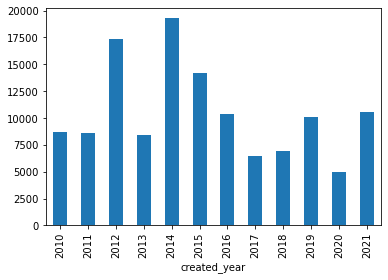

In [79]:
flood_gdf['created_year'] = pd.DatetimeIndex(flood_records['created_date']).year
flood_gdf.groupby('created_year')['unique_key'].count().plot.bar()

### Subset out last five years of 311 complaints

In [80]:
last_five_years = flood_gdf[flood_gdf['created_year']>=2016]

### Create point shapefile and export

In [ ]:
last_five_years = flood_gdf.to_file('processed_data/last_five_years_311_flooding.shp')

In [93]:
last_five_years_gdf = gpd.GeoDataFrame(last_five_years.drop(columns = 'geometry'), geometry = gpd.points_from_xy(last_five_years.longitude, last_five_years.latitude, crs="EPSG:4326"))
last_five_years = flood_gdf.to_file('processed_data/last_five_years_311_flooding.geojson', driver = 'GeoJSON')